In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from tqdm.notebook import tqdm_notebook

import spacy
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

import joblib

In [451]:
RUN_SPACY = True
version = '_customers'

# Load data

In [452]:
df = pd.read_csv('data/ciphix.csv', header=None, names=['text'])

In [453]:
df

,text
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...
1,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messages and no one is responding as usual
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...
4,@sprintcare I did.
...,...
2811769,"@823869 Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that w..."
2811770,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!
2811771,@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu servi...
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.co/7uQPwyH1B6"


# Look around

In [454]:
df.isna().sum()

text    0
dtype: int64

In [455]:
df["wordcount"] = df["text"].str.split().str.len()

<Axes: >

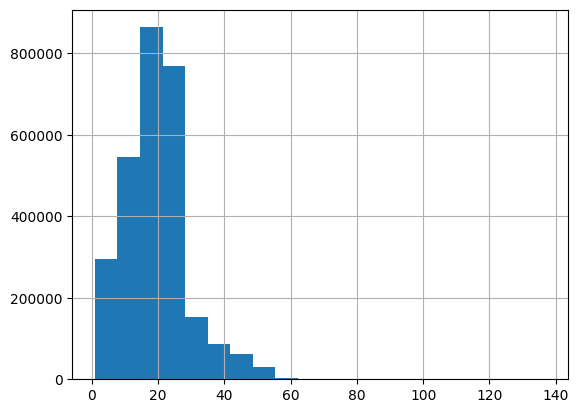

In [456]:
df['wordcount'].hist(bins=20)

In [457]:
df

,text,wordcount
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...,23
1,@sprintcare and how do you propose we do that,9
2,@sprintcare I have sent several private messages and no one is responding as usual,14
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...,23
4,@sprintcare I did.,3
...,...,...
2811769,"@823869 Hey, we'd be happy to look into this for you. Please send us a Direct Message, so that w...",25
2811770,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,15
2811771,@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu servi...,30
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.co/7uQPwyH1B6",6


### Conclusions

Looking around I noticed:
- all messages start with some kind of username handle
- some have multiple username handles
- some end with a different tag ^ followed by user acronym
- different languages
- smileys
- URLS


Text(0.5, 1.02, 'Counts of tag first-mentioned')

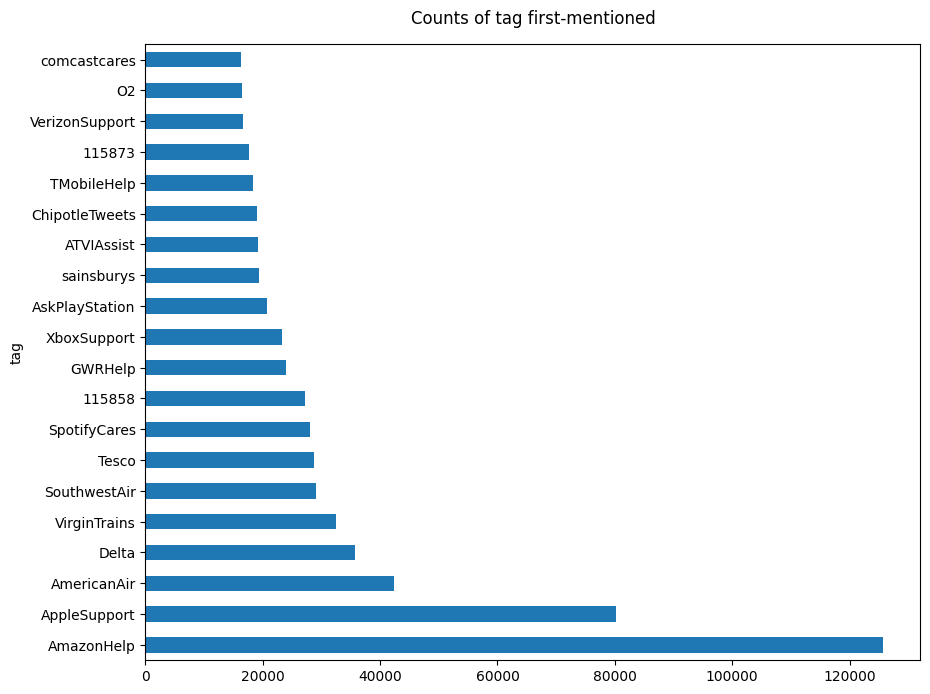

In [458]:
#Lets check the counts of the first tag mentioned
split = df['text'].str.extract(r'(@([a-zA-Z\d]+)([^\S\r\n]))(.*)')
split['text'] = split[3]
split['tag'] = split[1]
split = split[['tag','text']]
split = split.dropna(subset='text')
split['tag'].value_counts()[:20].plot(kind='barh', figsize=(10, 8))
plt.title("Counts of tag first-mentioned", y=1.02)

## Employee tag (^ or -)

After closer inspection I conclude that a {^,-} tag at the end must indicate a message that was written by a certain employee.
Since some of the topics that were found in the first seem to describe common phrases such as
- "Thank you for contacting the customer service"
- "Let me know if you need anything else"

I expect employer messages do not give any useful information for automation. That is why it is probably best to filter out any of the sentences that contain an employee tag. Although there are also empolyee messages without tags, this will at least help part of the way.

In [459]:
# Check the employee tag and save as indicator
df['has_empl_tag'] = df['text'].str.contains(r'[\^\-][A-Z\d]+[\s]*$')
df.head(n=20)

,text,wordcount,has_empl_tag
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...,23,False
1,@sprintcare and how do you propose we do that,9,False
2,@sprintcare I have sent several private messages and no one is responding as usual,14,False
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...,23,False
4,@sprintcare I did.,3,False
5,"@115712 Can you please send us a private message, so that I can gain further details about your ...",19,False
6,@sprintcare is the worst customer service,6,False
7,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",21,True
8,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,16,False
9,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so...",25,True


In [460]:
df['has_empl_tag'].sum()

404995

# Clean

In [461]:
#Remove all @ tags
def remove_ats(text):
    at_pattern = re.compile('@[a-zA-Z\d_]+')
    return at_pattern.sub(r'', text)

#Remove all employee tags
#Tags occur at the end of the line with capital letters and prefix '-' or '^'
def remove_tag(text):
    at_pattern = re.compile('[\^\-][A-Z\d]+$')
    return at_pattern.sub(r'', text)

#Remove URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Remove smileys
def remove_emoji(text):   
    emoji_pattern = re.compile("["
                            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "\U0001F300-\U0001F5FF"  # symbols & pictographs
                            "\U0001F600-\U0001F64F"  # emoticons
                            "\U0001F680-\U0001F6FF"  # transport & map symbols
                            "\U0001F700-\U0001F77F"  # alchemical symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove newlines.
def remove_specialchars(text):
    char_pattern = re.compile('[\n\'\"]')
    return char_pattern.sub(r'', text)

#Replace hashtags with spaces, these could be useful words so we want to recover them
def replace_hashtags(text):
    char_pattern = re.compile('[\#]')
    return char_pattern.sub(r' ', text)

def clean_df(df):
    df = df.apply(remove_ats) \
        .apply(remove_tag) \
        .apply(remove_urls) \
        .apply(remove_emoji) \
        .apply(remove_specialchars) \
        .apply(replace_hashtags) 
    return df

In [462]:
df['clean_text'] = clean_df(df['text'])                                   

### Wrapup and count words for employee vs customer

In [463]:
df = df.dropna(subset='clean_text')
print(df.shape)
df["wordcount"] = df["clean_text"].str.split().str.len()

(2811774, 4)


Text(0.5, 1.02, 'Wordcounts versus origin')

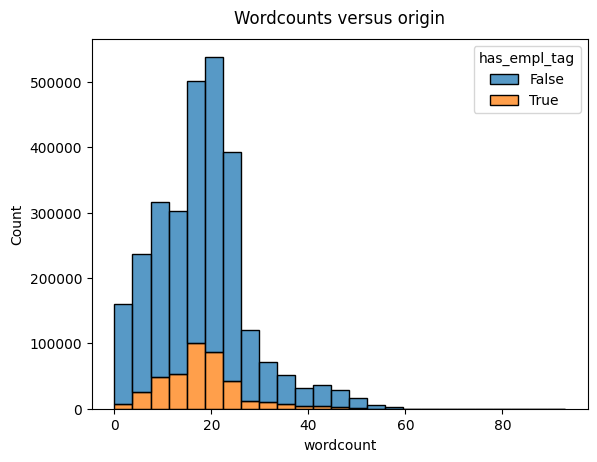

In [464]:
sns.histplot(data=df, x="wordcount", hue="has_empl_tag", bins=25, multiple="stack")
plt.title("Wordcounts versus origin", y=1.02)

### Inspect extreme cases

In [465]:
pd.set_option('display.max_rows', 50)
small = df.loc[df["wordcount"]<2,:].head(n=20)
small

,text,wordcount,has_empl_tag,clean_text
49,@VerizonSupport Yep,1,False,Yep
130,@ATVIAssist Thanks,1,False,Thanks
168,@AdobeCare ok,1,False,ok
182,@AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。,0,False,
183,@AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎてるので買い直しになるんでしょうね。,0,False,
184,@115770 カスタマーサービスにてお問い合わせ済みとのことで、お手数をおかけいたしました。リプライいただきありがとうございました。ET,1,False,ET
185,@AmazonHelp こちらこそありがとうございました。,0,False,
186,@115770 恐れ入ります。至らない点も多々あるかとは存じますが、今後ともどうぞよろしくお願いします。ET,1,False,ET
187,amazonのfireTVstickが見れない😢,1,False,amazonfireTVstick
235,amazonプライムビデオ、再生エラーが多いです,1,False,amazon


In [466]:
#Remove remaining text not containing letters
df = df[~df['clean_text'].str.fullmatch('^[\s\d]+$')] 

In [467]:
df.loc[df["wordcount"]<4,:].head(n=15)

,text,wordcount,has_empl_tag,clean_text
4,@sprintcare I did.,2,False,I did.
19,@115716 No thank you. ^JK,3,True,No thank you.
49,@VerizonSupport Yep,1,False,Yep
91,@115741 Noted 😊 -Becky,2,False,Noted -Becky
121,"@MicrosoftHelps @XboxSupport Brilliant, thank you!",3,False,"Brilliant, thank you!"
130,@ATVIAssist Thanks,1,False,Thanks
147,@ATVIAssist For double xp^,3,False,For double xp^
157,@AdobeCare sure thing,2,False,sure thing
164,@AdobeCare nope still down.,3,False,nope still down.
168,@AdobeCare ok,1,False,ok


In [468]:
#Short messages are not very informative, most of them seem to be "no, yes, thank you" variants
df = df[df["wordcount"]>3]

In [469]:
#Largest wordcounts seem only a few cases that I accept for now. Could do something with letter frequency distribution...
df.loc[df["wordcount"]>65,:]

,text,wordcount,has_empl_tag,clean_text
79293,@116230 I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HA...,66,False,I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU. I HATE YOU....
741778,@AppleSupport NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO N...,93,False,NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO...
1619605,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,68,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...
1764193,"@idea_cares रात भर मे बीस बार ये मैसेज आते है, जब कि रात मे हम कोई काल नही करते हैं और न ही डाटा...",69,False,"रात भर मे बीस बार ये मैसेज आते है, जब कि रात मे हम कोई काल नही करते हैं और न ही डाटा यूज करते ह..."
1956083,@AppleSupport \n\nI️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,66,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I...
1958113,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,68,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...
1961141,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,68,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...
1972751,.@116333 I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,68,False,. I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...
1991064,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,69,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...
2048019,I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ ...,68,False,I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I ...


### Only keep customer messages

In [470]:

df = df[~df['has_empl_tag']]
df

,text,wordcount,has_empl_tag,clean_text
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...,22,False,I understand. I would like to assist you. We would need to get you into a private secured link ...
1,@sprintcare and how do you propose we do that,8,False,and how do you propose we do that
2,@sprintcare I have sent several private messages and no one is responding as usual,13,False,I have sent several private messages and no one is responding as usual
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...,22,False,Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the...
5,"@115712 Can you please send us a private message, so that I can gain further details about your ...",18,False,"Can you please send us a private message, so that I can gain further details about your account?"
...,...,...,...,...
2811766,@134664 Can you Dm us your order number and we can look into this for you - Georgia,17,False,Can you Dm us your order number and we can look into this for you - Georgia
2811768,@VirginTrains Hope you are well? Does the 9.30am train from Crewe to Euston class as peak or off...,18,False,Hope you are well? Does the 9.30am train from Crewe to Euston class as peak or off-peak? Thanks
2811770,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,14,False,wtf!? I’ve been having really shitty service all day !! Get your shit together!
2811771,@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu servi...,26,False,You have to go to and ask them to add the Hulu service to your account. After you get the tex...


# Preprocessing

In [471]:
# We only need tokenizer, pos tagging and lemmatization
nlp = en_core_web_sm.load(disable=["parser", "ner", "textcat"])


In [472]:
"""
I select for Nouns, proper Nouns and Verbs since those will the most useful in a topic detection
in customer service setting with the end goal of automation.
"""

def preprocess(texts):
    docs = nlp.pipe(texts, n_process=10)
    output = []
    for doc in docs:
        pos_sel = " ".join(token.lemma_ for token in doc if (token.pos_ in ['PROPN','NOUN','VERB'] and not token.is_stop))
        output.append(pos_sel)
    return(output)


In [473]:
if RUN_SPACY:
    df['processed_text'] = preprocess(df['clean_text'])
    df.to_csv('data/ciphix_pre_processed_customers')
else:
    df = pd.read_csv(f'data/ciphix_pre_processed{version}', index_col=0)
df

,text,wordcount,has_empl_tag,clean_text,processed_text
0,@115712 I understand. I would like to assist you. We would need to get you into a private secure...,22,False,I understand. I would like to assist you. We would need to get you into a private secured link ...,understand like assist need secure link assist
1,@sprintcare and how do you propose we do that,8,False,and how do you propose we do that,propose
2,@sprintcare I have sent several private messages and no one is responding as usual,13,False,I have sent several private messages and no one is responding as usual,send message respond
3,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’...,22,False,Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the...,send message assist click message profile
5,"@115712 Can you please send us a private message, so that I can gain further details about your ...",18,False,"Can you please send us a private message, so that I can gain further details about your account?",send message gain detail account
...,...,...,...,...,...
2811766,@134664 Can you Dm us your order number and we can look into this for you - Georgia,17,False,Can you Dm us your order number and we can look into this for you - Georgia,dm order number look Georgia
2811768,@VirginTrains Hope you are well? Does the 9.30am train from Crewe to Euston class as peak or off...,18,False,Hope you are well? Does the 9.30am train from Crewe to Euston class as peak or off-peak? Thanks,hope 9.30am train Crewe Euston class peak peak thank
2811770,@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!,14,False,wtf!? I’ve been having really shitty service all day !! Get your shit together!,wtf have service day shit
2811771,@143549 @sprintcare You have to go to https://t.co/v2tMHeTL7Q and ask them to add the Hulu servi...,26,False,You have to go to and ask them to add the Hulu service to your account. After you get the tex...,ask add Hulu service account text


# Topic model

In [474]:


# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorized = vectorizer.fit_transform(df["processed_text"])


In [475]:
topic_count = 10

In [476]:
nmf = NMF(n_components=topic_count)
data_nmf = nmf.fit_transform(data_vectorized) 

In [477]:
def get_topics(nmf, vectorizer, topic_count):
    res = []
    for idx, topic in enumerate(nmf.components_):
        descr = [(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-topic_count - 1:-1]] #the final {topic_count} values in reverse
        res.append(descr)
    return res

In [478]:
topic_classes = get_topics(nmf, vectorizer, topic_count)

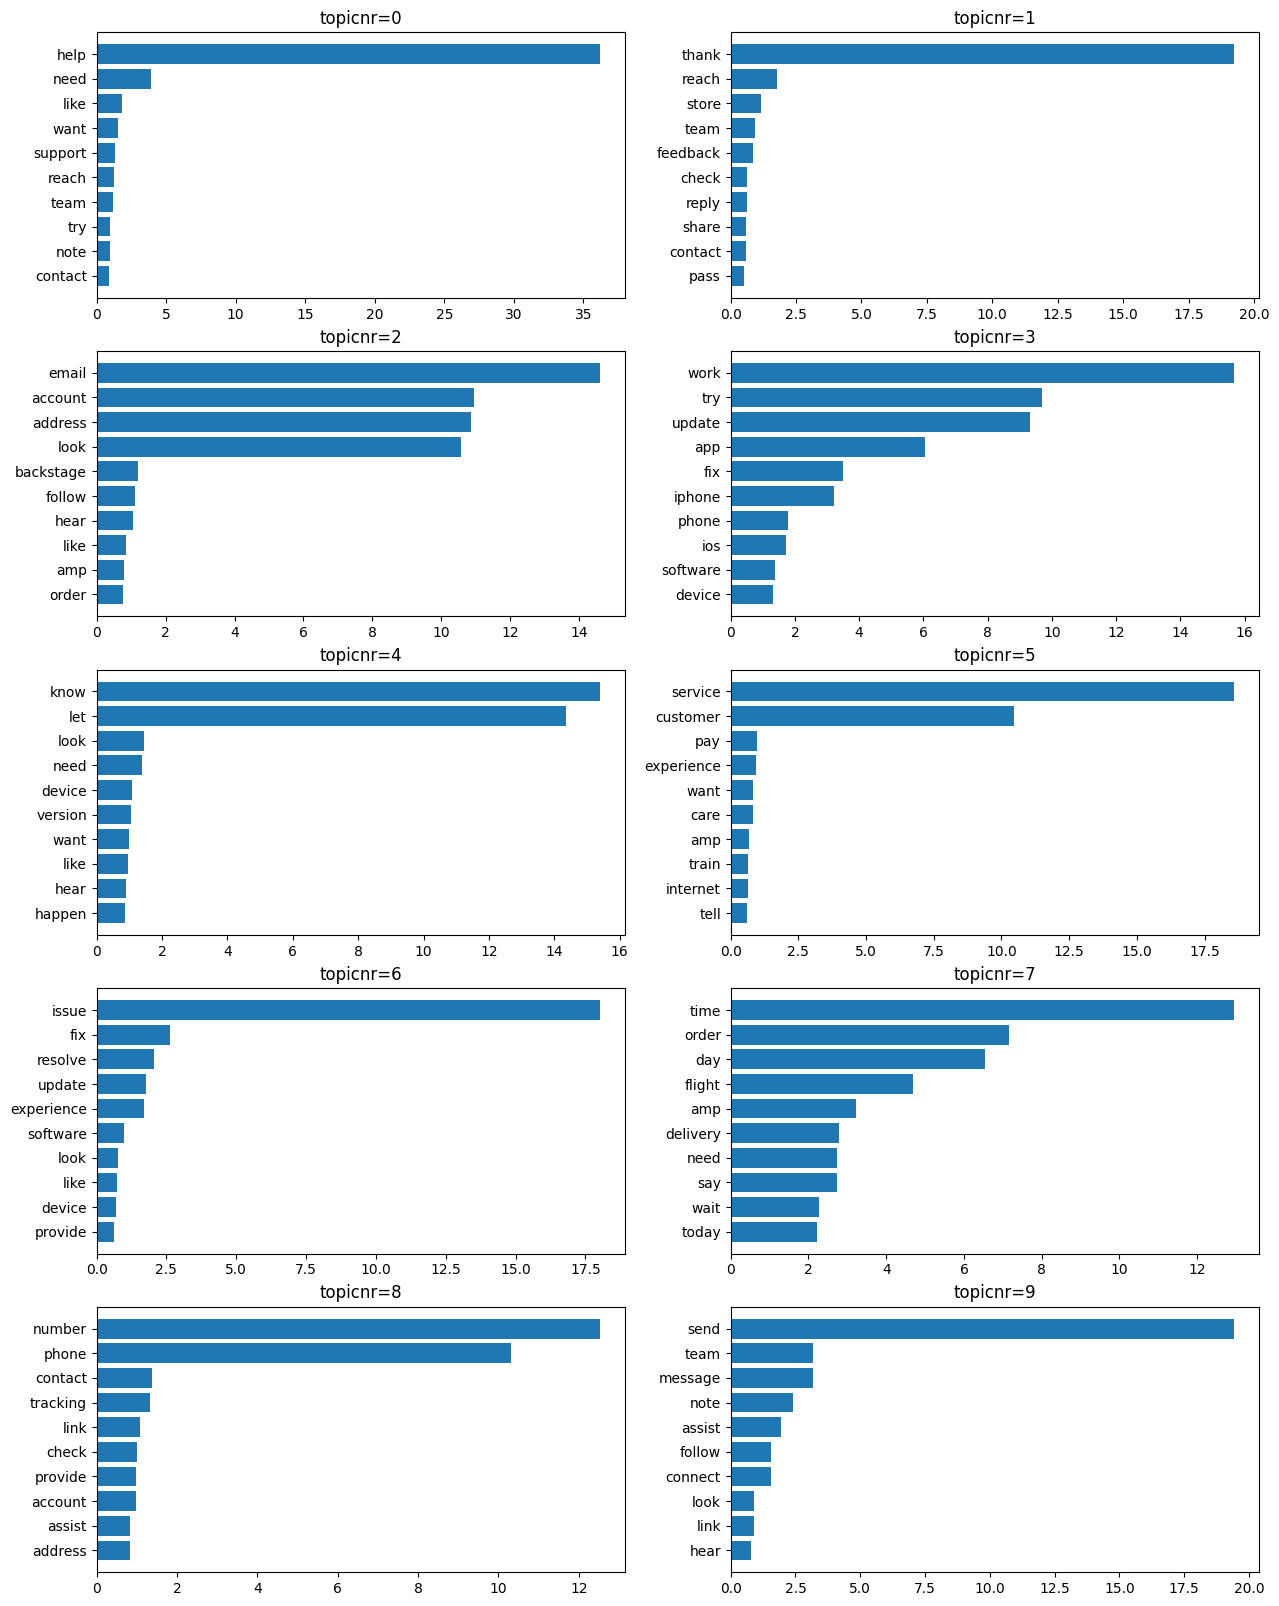

In [479]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
topicnr=0

for ax, topic_class in zip(axs.flat, topic_classes):
    resdf = pd.DataFrame(topic_class).rename(columns={0:'topic', 1:'score'})
    resdf = resdf.set_index('topic').iloc[::-1]
    ax.set_title(f'topicnr={topicnr}')
    ax.barh(resdf.index, resdf['score'], align='center')
    topicnr+=1
    

In [480]:
version = '_customers'

joblib.dump(nmf, f'models/nmf{version}.joblib')
joblib.dump(vectorizer, f'models/vectorizer{version}.joblib')
joblib.dump(clean_df, f'models/clean_df{version}.joblib')
joblib.dump(preprocess, f'models/preprocess{version}.joblib')

['models/preprocess_customers.joblib']

# Example inference new document

In [481]:
version = '_customers'

inf_nmf = joblib.load(f'models/nmf{version}.joblib')
inf_vectorizer = joblib.load(f'models/vectorizer{version}.joblib')
inf_clean_df = joblib.load(f'models/clean_df{version}.joblib')
inf_preprocess = joblib.load(f'models/preprocess{version}.joblib')

In [482]:
def get_topics(nmf, vectorizer, topic_count):
    res = []
    for idx, topic in enumerate(nmf.components_):
        descr = [(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-topic_count - 1:-1]] #the final {topic_count} values in reverse
        res.append(descr)
    return res

inf_topic_classes = get_topics(nmf, vectorizer, topic_count)

In [483]:
# Transform the new data with the fitted models
inf_doc = pd.DataFrame(["You should also treat your skills like cattle, not pets. Yes you specialized for 10yrs in a niche that is now threatened. Be grateful that you were able to milk that skill for 10yrs, but now it might be time to move on. There’s dignity in adaptation. It’s our human superpower."
                                ], dtype=str, columns=['text'])
display(inf_doc)

inf_doc['clean_text'] = inf_clean_df(inf_doc['text'])

inf_doc['processed_text'] = inf_preprocess(inf_doc['clean_text'])

newdata_vectorized = vectorizer.transform(inf_doc["processed_text"])
newdata_nmf = nmf.transform(newdata_vectorized) 



,text
0,"You should also treat your skills like cattle, not pets. Yes you specialized for 10yrs in a nich..."


In [484]:
inf_doc['processed_text']

0    treat skill cattle pet specialize 10yr niche threaten milk skill 10yr time dignity adaptation su...
Name: processed_text, dtype: object

In [485]:
# Get the top predicted topic
predicted_topic = [each.argsort()[::-1][0] for each in newdata_nmf]

[7]


In [486]:
print(newdata_nmf)

[[0.         0.         0.         0.         0.         0.
  0.         0.03258839 0.         0.        ]]


In [487]:
print([word for (word,_) in inf_topic_classes[predicted_topic[0]]])

['time', 'order', 'day', 'flight', 'amp', 'delivery', 'need', 'say', 'wait', 'today']
